In [1]:
import pandas as pd
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import numpy as np
import nltk
import random
import logging

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
from nltk.corpus import stopwords
# nltk.download("stopwords")
# nltk.download('punkt')
stop = set(stopwords.words('english'))

In [68]:
df = pd.read_csv('/Users/shrechak/Downloads/train.csv')
df['index1'] = df.index
df = df.fillna("")
df.shape

(404290, 7)

In [5]:
df.question2.isnull().value_counts()

False    404290
Name: question2, dtype: int64

In [53]:
df = df[:10000]

In [54]:
def get_words(question) :
    return list(filter(lambda word: word not in stop and word.isalpha(), nltk.word_tokenize(question.lower())))

In [55]:
getLabeledSentence = lambda given_tuple: [
             LabeledSentence(get_words(given_tuple[0]),["question1_"+str(given_tuple[2])]),  
             LabeledSentence(get_words(given_tuple[1]),["question2_"+str(given_tuple[2])])]

In [56]:
flatten = lambda l: [item for sublist in l for item in sublist]

sentences = flatten(list(map(lambda x: getLabeledSentence(x) , df[['question1', 'question2', 'index1']].values)))

In [57]:
len(sentences)

20000

In [58]:
model = Doc2Vec(min_count=1, window=10, size=1000, sample=1e-4, negative=5, workers=8)

In [59]:
model.build_vocab(sentences)

2017-04-19 01:54:37,999 : INFO : collecting all words and their counts
2017-04-19 01:54:38,001 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-19 01:54:38,072 : INFO : PROGRESS: at example #10000, processed 52633 words (760442/s), 9639 word types, 10000 tags
2017-04-19 01:54:38,121 : INFO : collected 13939 word types and 20000 unique tags from a corpus of 20000 examples and 104890 words
2017-04-19 01:54:38,122 : INFO : Loading a fresh vocabulary
2017-04-19 01:54:38,242 : INFO : min_count=1 retains 13939 unique words (100% of original 13939, drops 0)
2017-04-19 01:54:38,243 : INFO : min_count=1 leaves 104890 word corpus (100% of original 104890, drops 0)
2017-04-19 01:54:38,295 : INFO : deleting the raw counts dictionary of 13939 items
2017-04-19 01:54:38,297 : INFO : sample=0.0001 downsamples 708 most-common words
2017-04-19 01:54:38,298 : INFO : downsampling leaves estimated 75243 word corpus (71.7% of prior 104890)
2017-04-19 01:54:38,300 : INF

In [60]:
for epoch in range(100):
    random.shuffle(sentences)
    model.train(sentences)

2017-04-19 01:54:41,462 : INFO : training model with 8 workers on 13939 vocabulary and 1000 features, using sg=0 hs=0 sample=0.0001 negative=5 window=10
2017-04-19 01:54:41,466 : INFO : expecting 20000 sentences, matching count from corpus used for vocabulary survey
2017-04-19 01:54:42,496 : INFO : PROGRESS: at 1.91% examples, 8990 words/s, in_qsize 15, out_qsize 0
2017-04-19 01:54:43,691 : INFO : PROGRESS: at 17.22% examples, 37111 words/s, in_qsize 15, out_qsize 0
2017-04-19 01:54:44,702 : INFO : PROGRESS: at 20.95% examples, 31055 words/s, in_qsize 15, out_qsize 0
2017-04-19 01:54:45,979 : INFO : PROGRESS: at 34.34% examples, 36399 words/s, in_qsize 15, out_qsize 0
2017-04-19 01:54:47,471 : INFO : PROGRESS: at 49.55% examples, 39413 words/s, in_qsize 15, out_qsize 0
2017-04-19 01:54:49,140 : INFO : PROGRESS: at 64.80% examples, 40307 words/s, in_qsize 15, out_qsize 0
2017-04-19 01:54:50,243 : INFO : PROGRESS: at 80.06% examples, 43519 words/s, in_qsize 11, out_qsize 0
2017-04-19 01:

In [76]:
xaxis1 = []
xaxis2 = []
yaxis = []
for i in range(0, 100):
    x = model.docvecs['question1_'+str(i)]
    y = model.docvecs['question2_'+str(i)]
    xaxis1.append(np.dot(x,y))
    xaxis2.append(df.is_duplicate[i])
    yaxis.append(i)

In [77]:
import matplotlib.pyplot as plt

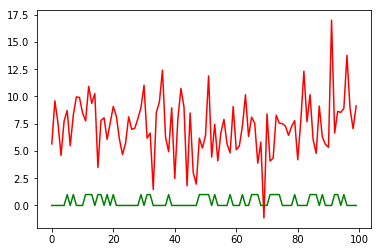

In [84]:
plt.plot(yaxis, xaxis1, "r", yaxis, xaxis2, "g")
plt.show()